In [48]:
library('tidyverse')
library('rvest')
library('lubridate')
library('ggrepel')
options(repr.plot.res = 300, repr.plot.width = 6, repr.plot.height = 6)

ERROR: Error in library("ggrepel"): there is no package called ‘ggrepel’


In [2]:
scrape_table = function(i, MF='Women\'s') {
    url = "https://www.baa.org/races/boston-marathon/results/champions"
    webpage = xml2::read_html(url)
    tbl = html_nodes(webpage, "table")[[i]] %>%
        html_table() %>%
        drop_na() %>%
        magrittr::set_colnames(c('year', 'name', 'country', 'time')) %>%
        mutate(time = hms(time)) %>%
        mutate(race.time = as.numeric(time, 'hours')) %>%
        mutate(MF = MF) %>%
        mutate(
            country.simple = ifelse(
                country %in% c('United States', 'Ethiopia', 'Japan', 'Kenya'),
                country,
                'other'
            )
        )
    tbl
}

df.men = scrape_table(1, MF='Men\'s')
df.women = scrape_table(2)

df.marathon = rbind(df.men, df.women)

Let's re-create this chart from FiveThirtyEight

<center>
    <img src="https://fivethirtyeight.com/wp-content/uploads/2018/04/wezerek-marathon-0416-13.png"
         style="width: 600px;"/>
</center>

Preview the data (i.e. `df.marathon`).

In [3]:
df.marathon |> head()

year,name,country,time,race.time,MF,country.simple
<int>,<chr>,<chr>,<Period>,<dbl>,<chr>,<chr>
2022,Evans Chebet,Kenya,2H 5M 54S,2.098333,Men's,Kenya
2022,Evans Chebet,Kenya,2H 6M 51S,2.114167,Men's,Kenya
2021,Benson Kipruto,Kenya,2H 9M 51S,2.164167,Men's,Kenya
2019,Lawrence Cherono,Kenya,2H 7M 57S,2.132500,Men's,Kenya
2018,Yuki Kawauchi,Japan,2H 15M 58S,2.266111,Men's,Japan
2017,Geoffrey Kirui,Kenya,2H 9M 37S,2.160278,Men's,Kenya


Fill in the table below:

| chart property | column name |
| --- | --- |
| x value | year |
| y value | race.time |
| color | country.simple |
| facet value | MF |

Make note of other aesthetic decisions. 
- What's the y-axis title?
- Do the two charts share the same x-axis bounds?
- Is there a legend?

Code your version of the chart below.

In [43]:
country_names_df = data.frame(
    country.simple = c('United States'),
    MF = c("Men's"),
    year = c(ymd('1920-01-01')),
    race.time = c(hms('2:05:54'))
)

country_names_df

country.simple,MF,year,race.time
<chr>,<chr>,<date>,<Period>
United States,Men's,1920-01-01,2H 5M 54S


In [52]:
country_names_df2 = df.marathon |>
    group_by(MF, country.simple) |>
    mutate(time = period_to_seconds(time) + 900) |>
    summarize(year = mean(year), time = mean(time)) |>
    mutate(time = seconds_to_period(time)) |>
    filter(country.simple != 'other')

country_names_df2 |> head()

`summarise()` has grouped output by 'MF'. You can override using the `.groups`
argument.


MF,country.simple,year,time
<chr>,<chr>,<date>,<Period>
Men's,Ethiopia,2007-11-01,2H 25M 19.5S
Men's,Japan,1971-09-01,2H 31M 38.3333333333339S
Men's,Kenya,2004-04-12,2H 23M 52.8799999999992S
Men's,United States,1935-02-03,2H 43M 28.8409090909099S
Women's,Ethiopia,2007-08-17,2H 39M 41.75S
Women's,Kenya,2010-09-25,2H 39M 47.1333333333332S


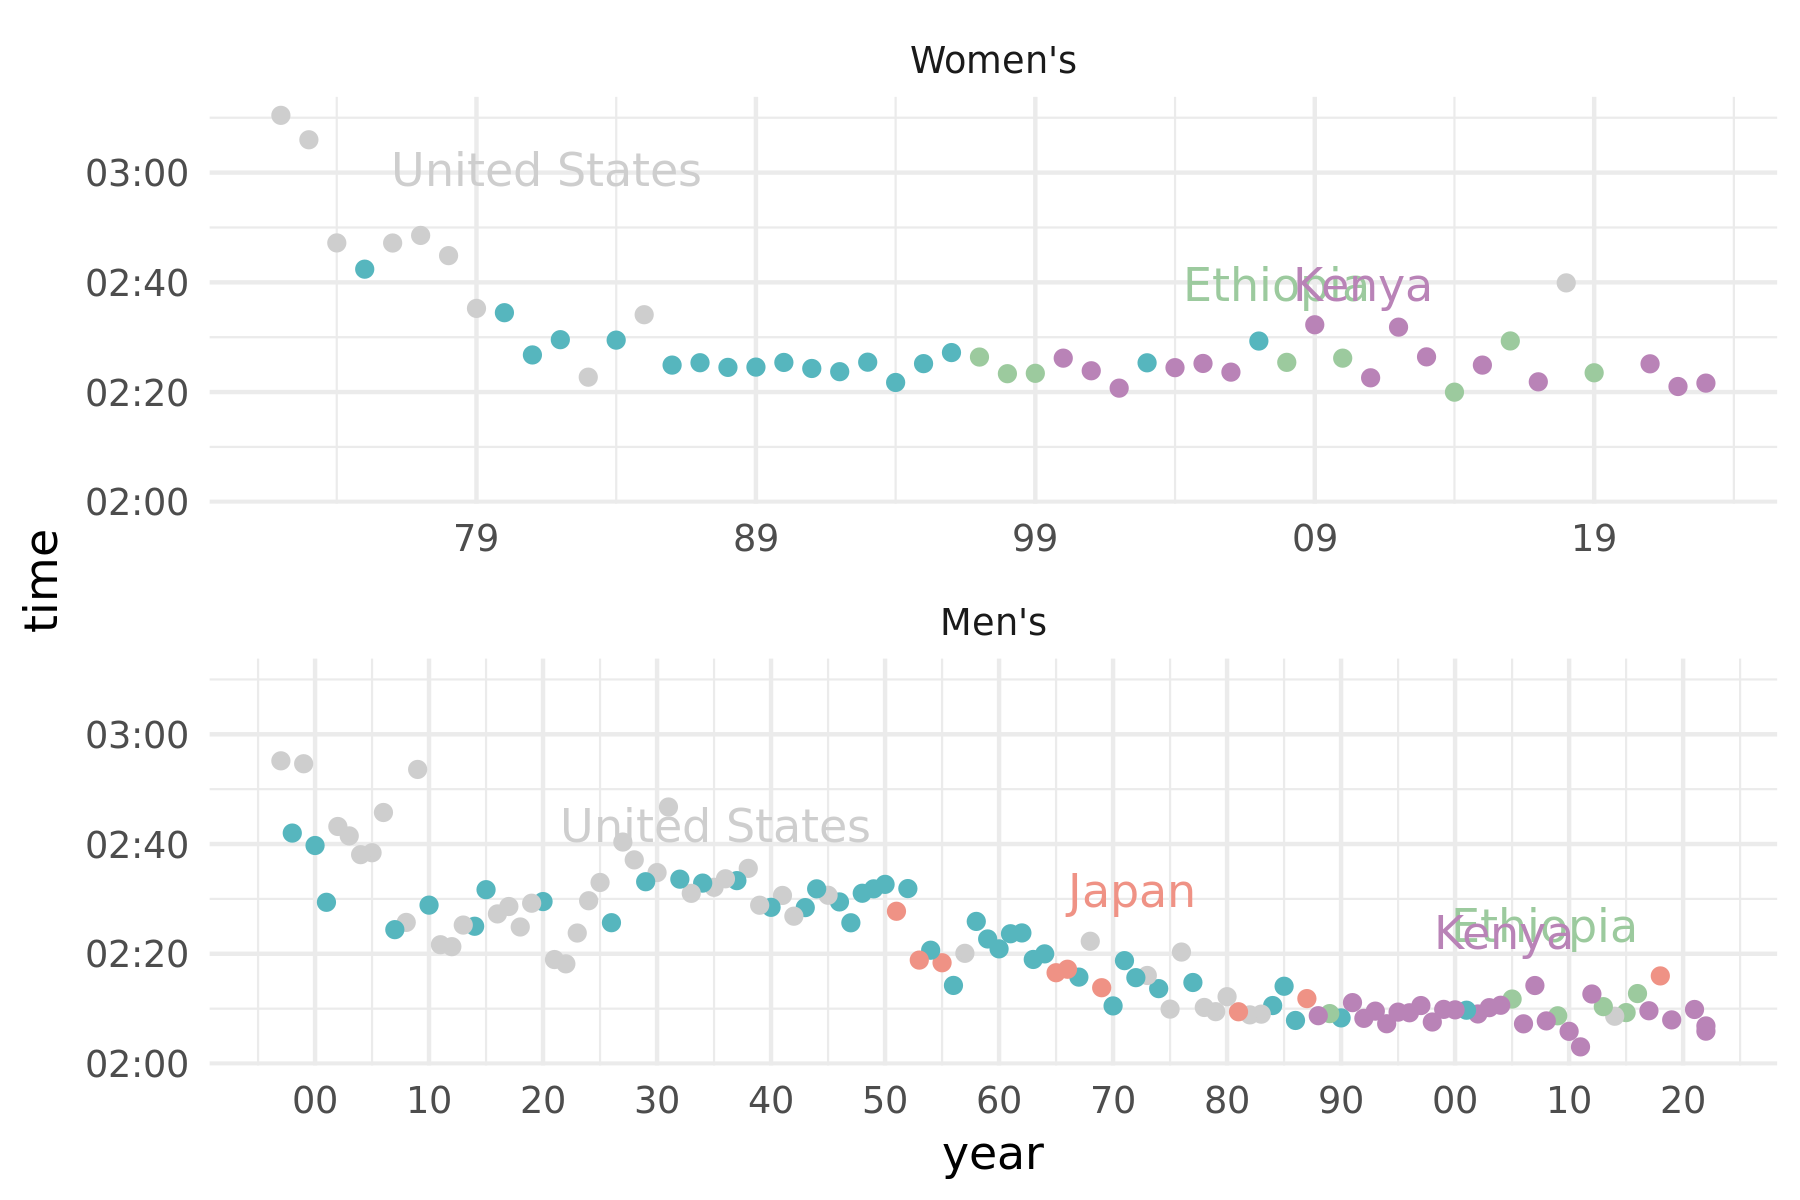

In [65]:
options(repr.plot.res = 300, repr.plot.width = 6, repr.plot.height = 4)

colors = c('#9cca9e', '#ef9285', '#b983b7', '#cecece', '#56b6be')

df.marathon = df.marathon |>
    mutate(year = as.Date(paste(year, 1, 1, sep = '-')))

p = ggplot(df.marathon, aes(x = year, y = time, color = country.simple)) +
    geom_point() +
    geom_text(data = country_names_df2, mapping = aes(label = country.simple)) +
    facet_wrap(~fct_rev(MF), ncol = 1, scale = 'free_x') +
    scale_y_time(labels = scales::label_time(format = '%H:%M')) +
    scale_x_date(date_breaks = '10 years', date_labels = '%y') +
    scale_color_manual(values = colors) +
    theme_minimal() +
    theme(legend.position = 'None')

p

What else might you visualize with this data? (e.g. What about totaling the winners from each country?)

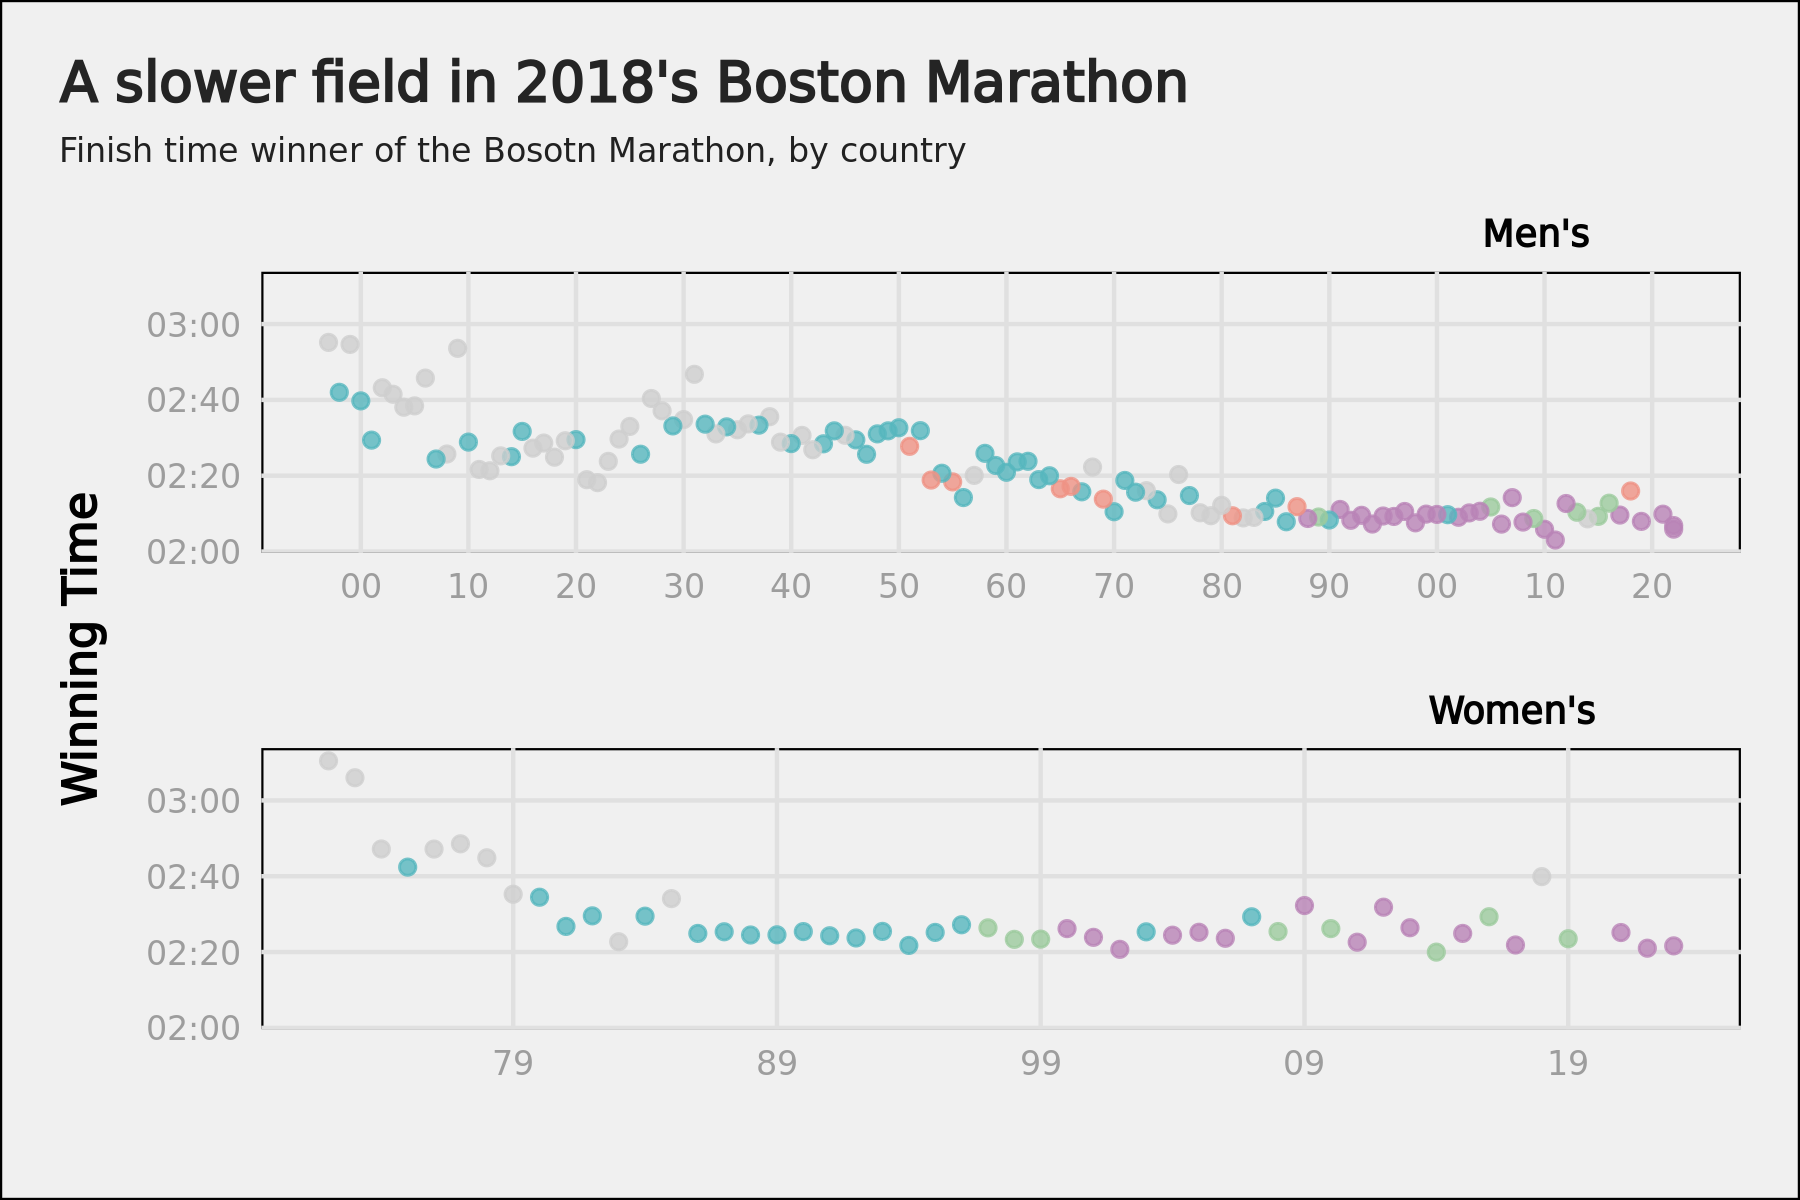

In [22]:
# Chuck's code

bg = c('#f0f0f0')

p2 = p + labs(x = '', y = 'Winning Time', title = "A slower field in 2018's Boston Marathon", 
            subtitle = 'Finish time winner of the Bosotn Marathon, by country') +
    theme(legend.position = 'None',
          plot.margin = margin(0.5, 0.5, 0.5, 0.5, "cm"),
          plot.subtitle = element_text(color = '#212121', size = 8),
          plot.title = element_text(color = '#242424', face = 'bold'),
          strip.text = element_text(hjust = 0.9, color = '#010101', face = 'bold'),
          plot.title.position = 'plot',
          plot.background = element_rect(fill = bg),
          panel.background = element_rect(fill = bg),
          strip.background = element_blank(),
          strip.placement = 'inside',
          panel.grid.major = element_line(color = '#e0e0e0'),
          panel.grid.minor = element_blank(),
          panel.spacing = unit(0.5, "cm"),
          axis.ticks = element_blank(),
          axis.title.y = element_text(face = 'bold', margin = margin(r = 10)),
          axis.text = element_text(color = '#9d9d9d', family = 'DecimaMonoPro', size = 8))

p2